# Fake Reviews Classification
---

In [2]:
# importing standard requried libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import random as rn
import itertools
# imports from scikit learn 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
# imports from tensorflow 
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_hub as hub
import tensorflow_text as text
# importing a stylesheet library for visualisations
sns.set(style='white')

In [3]:
# setting seeds so results are reproducable [1] 
import os
os.environ['PYTHONHASHSEED'] = '0'
seed = 420
np.random.seed(seed)
rn.seed(seed)
tf.random.set_seed(seed)

In [4]:
# loading the data from the csv file into a pandas' dataframe
dataframe = pd.read_csv("fake reviews dataset.csv")
dataframe.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


## Data preprocessing

Data is preprocessed by checking for null values, removing unnecessary columns, and adding new ones to help with exploratory data analysis. Then train-test splits of the data are created for use in the machine learning and deep learning models

In [5]:
print("number of null values: {}".format(dataframe.isnull().any(axis=1).sum()))

number of null values: 0


In [6]:
dataframe = dataframe.rename(columns={"text_":"text"}) # column rename
dataframe = dataframe.drop(["category"], axis=1) # remove category column

In [7]:
# added 2 new columns for EDA purposes
dataframe['text_length_char'] = dataframe['text'].apply(len) 
dataframe['text_length_word'] = dataframe['text'].apply(lambda x: len(x.split(' ')))
# renamed entries in label column for clarity 
dataframe['label'] = dataframe['label'].apply(lambda x: 'Fake' if x == "CG" else "Real")

# labels are encoded (0=fake, 1=real)
encoder = LabelEncoder()
encoder.fit(dataframe['label'])
dataframe['label_encoded'] = encoder.transform(dataframe['label'])
dataframe.head()

,rating,label,text,text_length_char,text_length_word,label_encoded
0,5.0,Fake,"Love this! Well made, sturdy, and very comfor...",75,14,0
1,5.0,Fake,"love it, a great upgrade from the original. I...",80,17,0
2,5.0,Fake,This pillow saved my back. I love the look and...,67,14,0
3,1.0,Fake,"Missing information on how to use it, but it i...",81,18,0
4,5.0,Fake,Very nice set. Good quality. We have had the s...,85,18,0


In [8]:
# neccessary data for the models is loaded from the dataframe into variables
x = dataframe["text"]
y = dataframe["label_encoded"]

In [9]:
# train-test splits are created with an 80:20 ratio and random_state is set to seed so results are reproducable 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed, shuffle=True)

In [10]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(32345,) (8087,) (32345,) (8087,)


## Exploratory data analysis

EDA reveals that the classes are balanced (proportion of fake and real reviews are equal) and word distributions between the two are not very different (as evident by the word clouds). However, reviews are skewed towards positive ratings which will have implications for assessing the impact of review sentiment/polarity. Review lengths are also skewed, with most being comparitvely shorther. 

In [11]:
# displaying a sample of reviews 
print("Examples of reviews:\n")
for i in range(0, 40000, 10000):
    print(dataframe['text'][i])

Examples of reviews:

Love this!  Well made, sturdy, and very comfortable.  I love it!Very pretty
Just bought a couple more as back ups.  I really like this remote and it works well for what I need it for.  I emailed Audiovox and they confirmed that this is the exact same remote as the RCR314WR but this one costs less.
Exactly as advertised. It is sturdy, easy to assemble, and just right my 8 pound puppy.
One of the true great books written about war in Afghanistan. I must read for everyone, especially those who love true war stories. Excellent and amazing bravery among soldiers of Red Platoon.


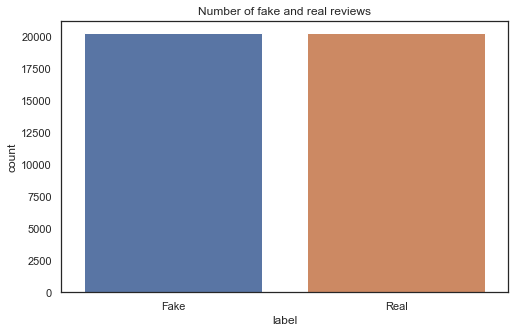

In [12]:
# dataset is balanced
plt.figure(figsize=(8,5))
sns.countplot(x = dataframe.label).set_title('Number of fake and real reviews');

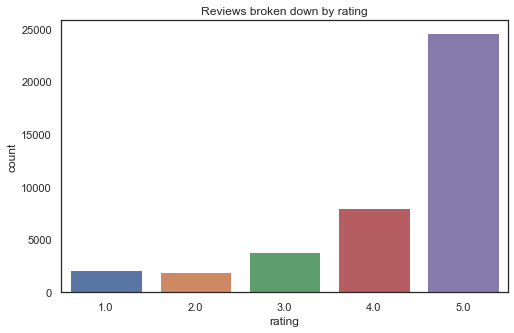

In [13]:
# review rating distributions 
plt.figure(figsize=(8,5))
sns.countplot(x = dataframe.rating).set_title('Reviews broken down by rating');

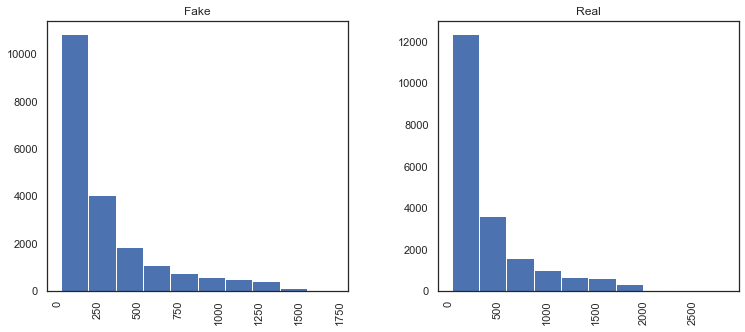

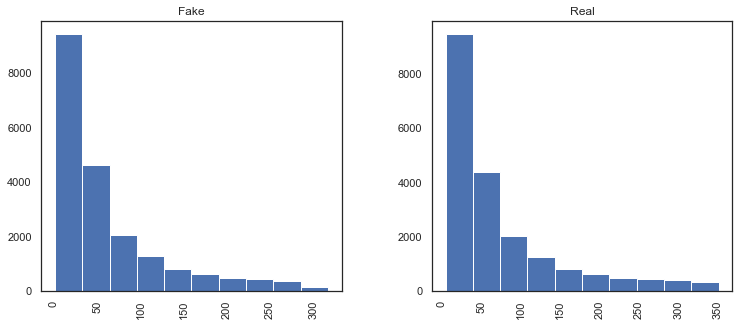

In [14]:
# review character length distributions 
dataframe.hist(column='text_length_char', by='label', figsize=(12, 5));
# review word length distributions 
dataframe.hist(column='text_length_word', by='label', figsize=(12, 5));

In [15]:
# wordclouds with top 50 most frequent words
wc = WordCloud(
    background_color='white', 
    max_words=50)

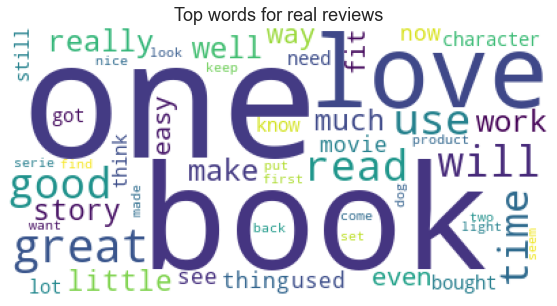

In [16]:
# real reviews word cloud
wc.generate(' '.join(text for text in dataframe.loc[dataframe['label'] == 'Real', 'text']))
plt.figure(figsize=(10,5))
plt.title('Top words for real reviews', fontsize=18)
plt.imshow(wc)
plt.axis("off");

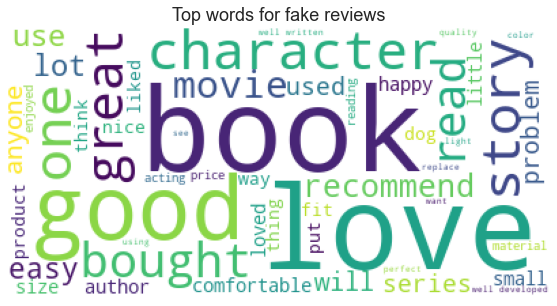

In [17]:
# fake reviews word cloud
wc.generate(' '.join(text for text in dataframe.loc[dataframe['label'] == 'Fake', 'text']))
plt.figure(figsize=(10,5))
plt.title('Top words for fake reviews', fontsize=18)
plt.imshow(wc)
plt.axis("off");

## Machine learning models

Before creting deep learning models using TensorFlow, standrad machine learning models are created using the Scikit learn library, to establish a benchmark performance. Two models are created: a naive bayes classifier and a support vector machine classifier. 

### Naive Bayes model

In [18]:
# function for creating multinomial naive bayes model which takes in 3 parameters: the type of vectorizer, ngrams and the 
# laplace smoothing value (alpha)
def naive(tfidf, n, smoothing):
    # first check which type of vectorizer to use
    if(tfidf==True):
        vectorizer = TfidfVectorizer(ngram_range=(n,n))
    else:
        vectorizer = CountVectorizer(ngram_range=(n,n)) 
    # create test and train features
    train_features = vectorizer.fit_transform(x_train)
    test_features = vectorizer.transform(x_test)
    # create multinomial naive bayes model
    NB = MultinomialNB(alpha=smoothing)
    NB.fit(train_features, y_train)
    # return test accuracy score
    return NB.score(test_features, y_test)

In [19]:
%%time 
ngrams = [1,2,3]
smoothing_values = [0.1, 1, 10]
# arrays for storing results
NB_cv_results = []
NB_tf_results = []

# loops create multiple models with different combinations of ngrams and laplace smoothing values
for n,alpha in itertools.product(ngrams, smoothing_values):
    NB_cv_results.append(naive(False, n, alpha)) # naive bayes with count vectorizer for feature extraction

for n,alpha in itertools.product(ngrams, smoothing_values):
    NB_tf_results.append(naive(True, n, alpha)) # naive bayes with tfidf vectorizer for fearure extraction

CPU times: total: 1min 13s
Wall time: 1min 13s


In [20]:
# results from the naive bayes model are stored into a pandas dataframe so they are easier to plot
NB_df = pd.DataFrame({'Ngrams': ['1', '1', '1', '2', '2', '2', '3', '3', '3'], 
                      'Alpha': ['0.1', '1', '10', '0.1', '1', '10', '0.1', '1', '10'],
                      'CountVectorizer Accuracy': [NB_cv_results[0], NB_cv_results[1], NB_cv_results[2], NB_cv_results[3],
                                  NB_cv_results[4], NB_cv_results[5], NB_cv_results[6], NB_cv_results[7], NB_cv_results[8]],
                      'TfidfVectorizer Accuracy': [NB_tf_results[0], NB_tf_results[1], NB_tf_results[2], NB_tf_results[3], NB_tf_results[4], 
                                  NB_tf_results[5], NB_tf_results[6], NB_tf_results[7], NB_tf_results[8]]})

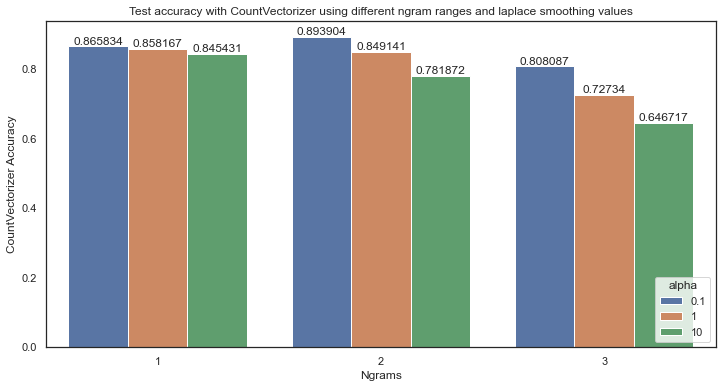

In [21]:
# bar chart of naive bayes test accuracies 
plt.figure(figsize=(12,6))
ax = sns.barplot(x='Ngrams', y='CountVectorizer Accuracy', hue='Alpha', data=NB_df);
ax.legend(loc='lower right', title='alpha')
ax.bar_label(ax.containers[0]);
ax.bar_label(ax.containers[1]);
ax.bar_label(ax.containers[2]);
plt.title('Test accuracy with CountVectorizer using different ngram ranges and laplace smoothing values');

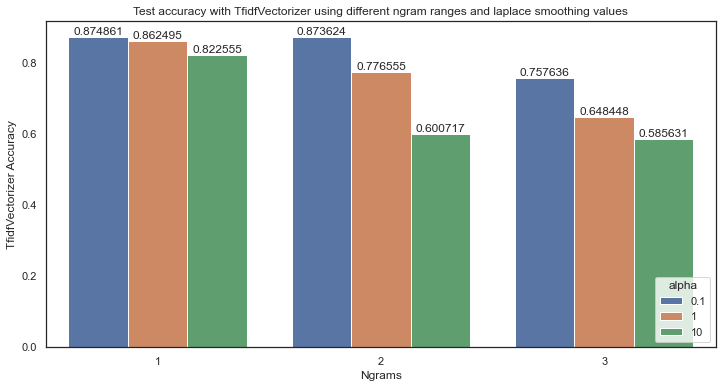

In [22]:
# bar chart of naive bayes test losses  
plt.figure(figsize=(12,6))
ax = sns.barplot(x='Ngrams', y='TfidfVectorizer Accuracy', hue='Alpha', data=NB_df);
plt.legend(loc='lower right', title='alpha')
ax.bar_label(ax.containers[0]); 
ax.bar_label(ax.containers[1]);
ax.bar_label(ax.containers[2]);
plt.title('Test accuracy with TfidfVectorizer using different ngram ranges and laplace smoothing values');

Results show that best performing model used CountVectorizer as the feature extraction method, with bigram (ngram=2) features and a laplace smoothing value (alpha) of 0.1. Further modifications are then made below on this best performing model. These include stop word removal and only checking for word/token occurance (disregarding count/occurance of tokens).

In [23]:
def naive2(cv):
    train_features = cv.fit_transform(x_train)
    test_features = cv.transform(x_test)
    NB = MultinomialNB(alpha=0.1)
    NB.fit(train_features, y_train)
    return NB.score(test_features, y_test)

In [24]:
cv = CountVectorizer(ngram_range=(2,2), stop_words="english")
print("Accuracy with stop words is: {}".format(naive2(cv)))
cv = CountVectorizer(ngram_range=(2,2), binary=True)
print("Accuracy with binary presence: (no counts) {}".format(naive2(cv)))

Accuracy with stop words is: 0.7745764807716088
Accuracy with binary presence: (no counts) 0.886979102262891


As expected, stop word removal causes the loss of valuable information thus drastically reducing model performance. Just using the binary presence of tokens over their occurance showed no benefit either in terms of test accuracy. 

### Support Vector Machine model

In [25]:
%%time
# countVectorizer called again to just model with unigram features
cv = CountVectorizer()
train_features = cv.fit_transform(x_train)
test_features = cv.transform(x_test)
# arrray of c values create which govern the amount of misclassification that is permitted in the model
c_values = [0.1, 0.5]
# linear support vector machines created using different c values 
for c in c_values:
    linear_svm = svm.SVC(C=c)
    linear_svm.fit(train_features, y_train)
    print("accuracy is with c value of {} is: {}".format(c, linear_svm.score(test_features, y_test)))

accuracy is with c value of 0.1 is: 0.8324471373809819
accuracy is with c value of 0.5 is: 0.8778286138246568
CPU times: total: 8min 26s
Wall time: 8min 26s


In [26]:
# look at note1 for this section 

## Deep Learning sequence preperation 

The text data must first be prepared (tokenised and padded) before it can be used by TensorFlow neural networks. Multiple configurations of different neural networks are created, trained and evaluated. Broadly, they can be split into 3 categories:
1. Multilayer Perceptrons (standard neural networks)
2. Long short-term memory recurrent neural networks 
3. BERT model (transformer based neural networks)

In [27]:
# tokenization function created as text will need to be tokenized multiple times using different vocabulary sizes 
def tokenize(vocab_size):
    tokenizer = Tokenizer(oov_token = '<OOV>', num_words = vocab_size) # out of vocabulary token specified
    tokenizer.fit_on_texts(x_train) # only fit to training data
    word_index = tokenizer.word_index
    # tokenizing training and testing and converting into sequences of tokens
    train_sequences = tokenizer.texts_to_sequences(x_train)
    test_sequences = tokenizer.texts_to_sequences(x_test)
    return train_sequences, test_sequences, word_index

In [28]:
# padding function created as sequences will be padded to different lengths to find the best length
def padding(max_length):
    # padding on training and testing sequences so they are of same length [2]. Sequences are padded and trunucated at the end
    train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length, truncating='post') 
    test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length, truncating='post')
    return train_padded, test_padded

MLP is going to be tested on entire vocabulary with padding up to the length of the largest sequence. 

In [29]:
train_sequences, test_sequences, word_index = tokenize(None) # none means tokenize on enitre vocabulary

In [30]:
vocab_size = len(word_index)
print("Number of unique tokens in training data: {}".format(vocab_size)) # checks how many words 

Number of unique tokens in training data: 39143


In [31]:
max_token_length = max([len(x) for x in train_sequences])
print("maximum tokenized sentence length in training data: {}".format(max_token_length))

maximum tokenized sentence length in training data: 504


In [32]:
train_padded, test_padded = padding(max_token_length) # pads all sequences to the length of largest sequence
# Before padding lengths
print(len(train_sequences[0]), len(train_sequences[1]), len(test_sequences[0]), len(test_sequences[1]))
# After padding lengths
print(len(train_padded[0]), len(train_padded[1]), len(test_padded[0]), len(test_padded[1]))

22 12 17 16
504 504 504 504


## Multilayer Perceptron

First, a multilayer perceptron (MLP) is created to show the performance of a simple artificial neural network in comparison to the other machine learning models. Also, a justification for the use of an LSTM can only be made if it shows outperformance over a MLP. 

*Note: Only a single hidden layer is used in an MLP so it is technically not a deep learning neural network. However, it is kept in this section for ease of readability*

In [33]:
# number of epochs and proportion of training data that will be used for validation are set at the start and are shared values
# across all neural networks created
num_epochs = 25
val_split = 0.2

In [34]:
# function is defined to build the model with different neurons (passed as a parameter)   
def build_mlp(neurons):
  mlp = tf.keras.models.Sequential([
    # dense layer with relu activation function
    tf.keras.layers.Dense(neurons, activation='relu'),
    # sigmoid layer with 1 neuron to classify the sample/review as either fake or real
    tf.keras.layers.Dense(1, activation="sigmoid")
  ])
  mlp.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
  return mlp

# keras callbacks are used to implement early stopping. Validation accuracy is used as the metric for early stopping and a
# minimum delta of 0.01 is specified (minimal increase in validation accuracy neccessary to be conisdered an improvement). If
# 5 epochs pass with no improvement then training stops and the best weights (achieved highest accuracy) are restored 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.01, mode='max', restore_best_weights=True)

In [35]:
# arrays to store each models results  
mlp_history, mlp_test_loss, mlp_test_acc = [], [], []

# batch sizes and number of neurons that will be tested
batch_sizes = [32, 64, 128] 
neurons = [32, 64, 128] 

# nested for loops to iteratively create neural networks with numbers of neurons and batch sizes
for y in range(len(neurons)):
    mlp = build_mlp(neurons[y])
    for x in range(len(batch_sizes)):
        mlp_history.append(mlp.fit(train_padded, y_train, epochs=num_epochs, batch_size=batch_sizes[x], validation_split=0.2, 
                            shuffle=True, callbacks=[callback], verbose=0))                
        test_loss, test_acc = mlp.evaluate(test_padded,  y_test, verbose=0)
        mlp_test_loss.append(test_loss)
        mlp_test_acc.append(test_acc)

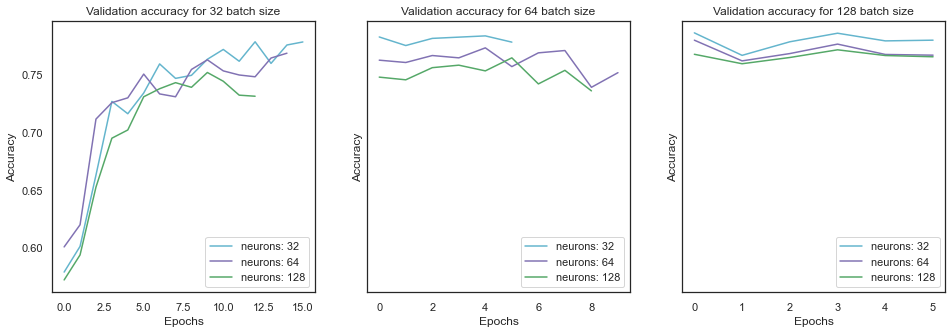

In [36]:
# line charts to show the progression of the validation accuracy across each model for each batch size and learning rate
fig, axs = plt.subplots(1,3,figsize=(16,5), sharey = True)
# plot 1
axs[0].plot(mlp_history[0].history['val_accuracy'],'c') 
axs[0].plot(mlp_history[3].history['val_accuracy'],'m')
axs[0].plot(mlp_history[6].history['val_accuracy'],'g')
axs[0].set_title('Validation accuracy for 32 batch size')
axs[0].set_ylabel('Accuracy') 
axs[0].set_xlabel('Epochs')
axs[0].legend(['neurons: 32', 'neurons: 64', 'neurons: 128'], loc='lower right')
# plot 2
axs[1].plot(mlp_history[1].history['val_accuracy'],'c') 
axs[1].plot(mlp_history[4].history['val_accuracy'],'m')
axs[1].plot(mlp_history[7].history['val_accuracy'],'g')
axs[1].set_title('Validation accuracy for 64 batch size')
axs[1].set_ylabel('Accuracy') 
axs[1].set_xlabel('Epochs')
axs[1].legend(['neurons: 32', 'neurons: 64', 'neurons: 128'], loc='lower right')
# plot 3
axs[2].plot(mlp_history[2].history['val_accuracy'],'c') 
axs[2].plot(mlp_history[5].history['val_accuracy'],'m')
axs[2].plot(mlp_history[8].history['val_accuracy'],'g')
axs[2].set_title('Validation accuracy for 128 batch size')
axs[2].set_ylabel('Accuracy') 
axs[2].set_xlabel('Epochs')
axs[2].legend(['neurons: 32', 'neurons: 64', 'neurons: 128'], loc='lower right')
plt.show()

In [37]:
# dataframe created to store test results of the MLP experiments so they can be easily plotted 
mlp_df = pd.DataFrame({'Neurons': ['32', '32', '32', '64', '64', '64', '128', '128', '128'],
                       'Batch Size': ['32', '64', '128', '32', '64', '128', '32', '64', '128'],
                       'Test accuracy': [mlp_test_acc[0], mlp_test_acc[1], mlp_test_acc[2], mlp_test_acc[3], mlp_test_acc[4], 
                                         mlp_test_acc[5], mlp_test_acc[6], mlp_test_acc[7], mlp_test_acc[8]],
                       'Test loss': [mlp_test_loss[0], mlp_test_loss[1], mlp_test_loss[2], mlp_test_loss[3], mlp_test_loss[4], 
                                         mlp_test_loss[5], mlp_test_loss[6], mlp_test_loss[7], mlp_test_loss[8]]})

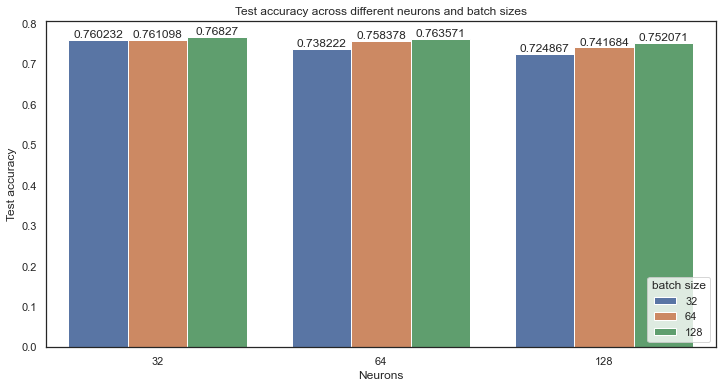

In [38]:
# bar chart of mlp test accuracies created 
plt.figure(figsize=(12,6))
ax = sns.barplot(x='Neurons', y='Test accuracy', hue='Batch Size', data=mlp_df);
plt.legend(loc='lower right', title='batch size')
ax.bar_label(ax.containers[0]);
ax.bar_label(ax.containers[1]);
ax.bar_label(ax.containers[2]);
plt.title('Test accuracy across different neurons and batch sizes');

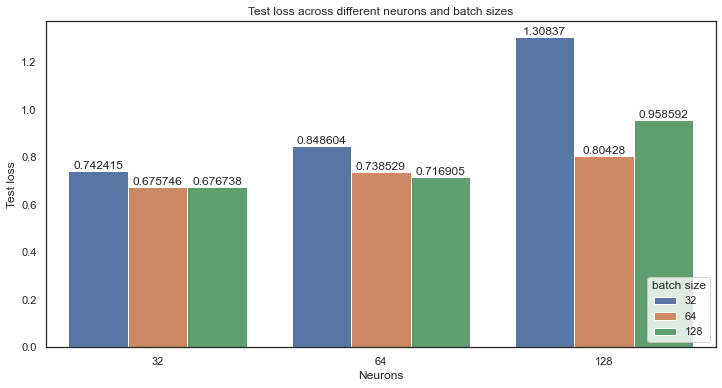

In [39]:
# bar chart of mlp test losses created 
plt.figure(figsize=(12,6))
ax = sns.barplot(x='Neurons', y='Test loss', hue='Batch Size', data=mlp_df);
plt.legend(loc='lower right', title='batch size')
ax.bar_label(ax.containers[0]); 
ax.bar_label(ax.containers[1]);
ax.bar_label(ax.containers[2]);
plt.title('Test loss across different neurons and batch sizes');

In [40]:
# given length distribtuons, it is not good to pad to largest sequence 

In [41]:
# trunicating is set to post as gpt models can produce outputs that become/have higher likelihood of becoming, nonsensical 
# towards the end. Thus, retaining trunicaintg earlier seq information = more robust model as problem is more challenging

In [42]:
## oov token is set to retain order/structure of seq?

In [43]:
# lower num words/vocab size will increase oov if has been set. too many oovs is not good becaus all have same context
# However, Means get less words but more likely to filter out info that is not really sueful to classification

In [44]:
# alternatives to oov exist such as work by: https://arxiv.org/pdf/1707.06961.pdf but improvments in results were mot
# substantial enough to warrent/justify the additional computational cost which would increase the training time 

## Long Short-Term Memory Recurrent Neural Networks

The basic MLP was unable to achieve an accuracy higher than the scikit learn machine learning models. This warrants the use of more complex LSTM architectures. Many configurations are implemented and tested

### LSTM_1

In [45]:
# function created to test multiple different hyparemeter values on the same architecture
def build_lstm_1(neurons, vocab_size, embed_dim, max_length):
  lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length),
    tf.keras.layers.LSTM(neurons, return_sequences=False, activation='tanh'), 
    tf.keras.layers.Dense(1, activation="sigmoid")
  ])
  lstm_1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
  return lstm_1

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.01, mode='max', restore_best_weights=True)

In [46]:
lstm_history, lstm_test_loss, lstm_test_acc = [], [], []

neurons = [32, 64, 128] # array for different number of neurons
for y in range(len(neurons)):
    lstm_1 = build_lstm_1(neurons[y], vocab_size+1, 16, max_token_length)        
    lstm_history.append(lstm_1.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=0))                
    test_loss, test_acc = lstm_1.evaluate(test_padded, y_test, verbose=0)
    lstm_test_loss.append(test_loss)
    lstm_test_acc.append(test_acc)

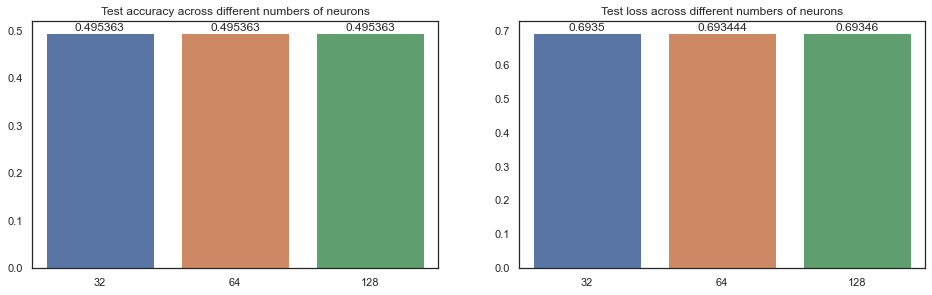

In [47]:
fig, axs = plt.subplots(1,2,figsize=(16,10))
plt.subplot(221)
ax = sns.barplot(x=neurons, y=lstm_test_acc);
ax.bar_label(ax.containers[0]);
plt.title('Test accuracy across different numbers of neurons');
plt.subplot(222)
ax = sns.barplot(x=neurons, y=lstm_test_loss);
ax.bar_label(ax.containers[0]);
plt.title('Test loss across different numbers of neurons');

The number of neurons has no noticable affect on the LSTM performance. Other parameter adjustments are explored with the number of neurons being set to 32 since fewer neurons are less commputationally demanding

In [48]:
lstm_history, lstm_test_loss, lstm_test_acc = [], [], []

max_lengths = [10, 25, 50, 100, 250] # array of different padding lengths
for y in range(len(max_lengths)):
    # padding function called to experiment with different sequence lengths
    train_padded, test_padded = padding(max_lengths[y])
    lstm_1 = build_lstm_1(32, vocab_size+1, 16, max_lengths[y])        
    lstm_history.append(lstm_1.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=0))                
    test_loss, test_acc = lstm_1.evaluate(test_padded, y_test, verbose=0)
    lstm_test_loss.append(test_loss)
    lstm_test_acc.append(test_acc)

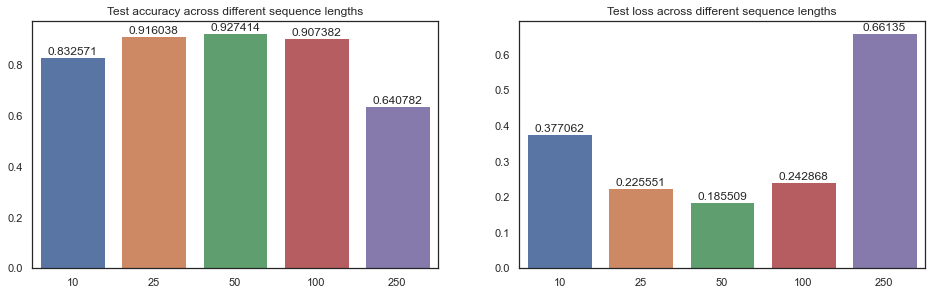

In [49]:
fig, axs = plt.subplots(1,2,figsize=(16,10))
plt.subplot(221)
ax = sns.barplot(x=max_lengths, y=lstm_test_acc);
ax.bar_label(ax.containers[0]);
plt.title('Test accuracy across different sequence lengths');
plt.subplot(222)
ax = sns.barplot(x=max_lengths, y=lstm_test_loss);
ax.bar_label(ax.containers[0]);
plt.title('Test loss across different sequence lengths');

Changing the padding greatly increases the performance of the LSTM. A max sequence length of 50 is the most optimal choice because it has the highest test accuracy and lowest test loss 

In [50]:
lstm_history, lstm_test_loss, lstm_test_acc = [], [], []

vocab_sizes = [1000, 5000, 10000, 25000, 35000] # array of different vocabulary sizes
for y in range(len(vocab_sizes)):
    # tokenize and padding functions called to adjust to the different vocabulary sizes
    train_sequences, test_sequences, word_index = tokenize(vocab_sizes[y])
    train_padded, test_padded = padding(50)
    
    lstm_1 = build_lstm_1(32, vocab_sizes[y], 16, 50)        
    lstm_history.append(lstm_1.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=0))                
    test_loss, test_acc = lstm_1.evaluate(test_padded, y_test, verbose=0)
    lstm_test_loss.append(test_loss)
    lstm_test_acc.append(test_acc)

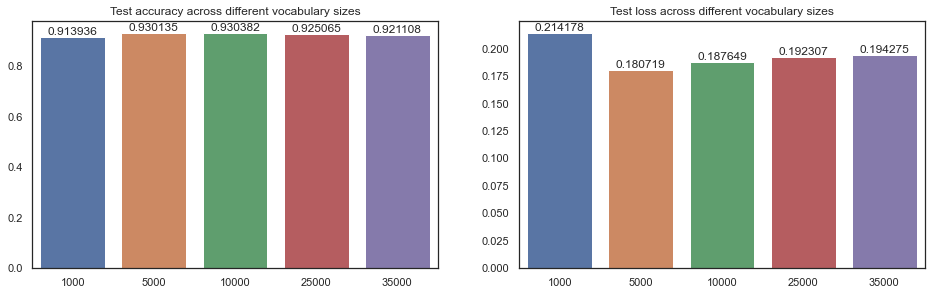

In [51]:
fig, axs = plt.subplots(1,2,figsize=(16,10))
plt.subplot(221)
ax = sns.barplot(x=vocab_sizes, y=lstm_test_acc);
ax.bar_label(ax.containers[0]);
plt.title('Test accuracy across different vocabulary sizes');
plt.subplot(222)
ax = sns.barplot(x=vocab_sizes, y=lstm_test_loss);
ax.bar_label(ax.containers[0]);
plt.title('Test loss across different vocabulary sizes');

Changing the vocabulary size causes a marginal improvement in the performance of the LSTM. A size of 5000 is the most optimal choice because it has one of the highest test accuracies and the clearly lowest test loss

In [52]:
# tokenize and padding functions are called with a padding of 50 and vocabulary size of 5000 which all future models will use 
train_sequences, test_sequences, word_index = tokenize(5000)
train_padded, test_padded = padding(50)

In [53]:
lstm_history, lstm_test_loss, lstm_test_acc = [], [], []

emb_sizes = [8, 16, 32, 64, 128] # embedding vector sizes
for y in range(len(emb_sizes)):
    lstm_1 = build_lstm_1(32, 5000, emb_sizes[y], 50)        
    lstm_history.append(lstm_1.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=0))                
    test_loss, test_acc = lstm_1.evaluate(test_padded, y_test, verbose=0)
    lstm_test_loss.append(test_loss)
    lstm_test_acc.append(test_acc)

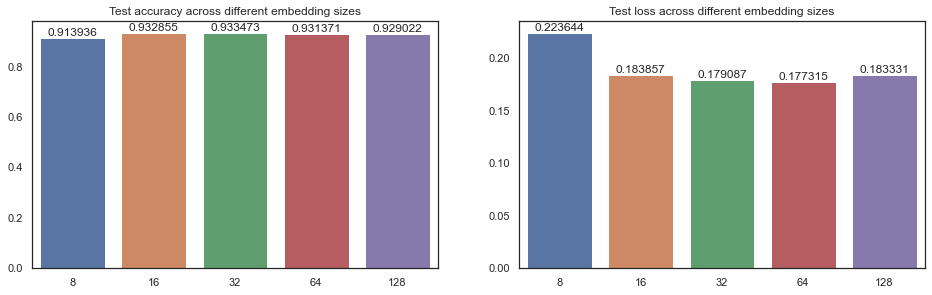

In [54]:
fig, axs = plt.subplots(1,2,figsize=(16,10))
plt.subplot(221)
ax = sns.barplot(x=emb_sizes, y=lstm_test_acc);
ax.bar_label(ax.containers[0]);
plt.title('Test accuracy across different embedding sizes');
plt.subplot(222)
ax = sns.barplot(x=emb_sizes, y=lstm_test_loss);
ax.bar_label(ax.containers[0]);
plt.title('Test loss across different embedding sizes');

Changing the embedding size causes a marginal improvement in the performance of the LSTM. A size of 32 is the most optimal choice both in terms of test accuracy and test loss

In [55]:
lstm_1 = build_lstm_1(32, 5000, 32, 50)        
lstm_1_history = lstm_1.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=0)              
test_loss, test_acc = lstm_1.evaluate(test_padded, y_test, verbose=0)

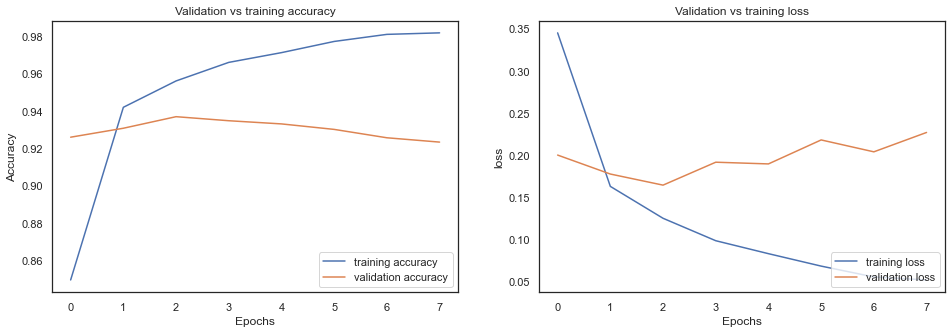

In [56]:
fig, axs = plt.subplots(1,2,figsize=(16,5))
axs[0].plot(lstm_1_history.history['accuracy']) 
axs[0].plot(lstm_1_history.history['val_accuracy']) 
axs[0].set_title('Validation vs training accuracy')
axs[0].set_ylabel('Accuracy') 
axs[0].set_xlabel('Epochs')
axs[0].legend(['training accuracy', 'validation accuracy'], loc='lower right')

axs[1].plot(lstm_1_history.history['loss']) 
axs[1].plot(lstm_1_history.history['val_loss']) 
axs[1].set_title('Validation vs training loss')
axs[1].set_ylabel('loss') 
axs[1].set_xlabel('Epochs')
axs[1].legend(['training loss', 'validation loss'], loc='lower right')
plt.show()

In [57]:
print("Accuracy on test data: {acc:.3f}".format(acc=test_acc))
print("Loss on test data: {loss:.3f}".format(loss=test_loss))

Accuracy on test data: 0.928
Loss on test data: 0.186


### LSTM_1 regularized

Although a very high test accuracy is achieved (over 90%), there is still room for improvement. The difference between the validation and training accuracies suggests the model may be overfitting and regularization techniques are required. These include dropout and batch normalisation. Dropout is applied to two models in two different ways. In one, it is incorperated directly into the LSTM layer, and in the other, it is added as a dropout layer.  

In [58]:
# dropout is directly applied to LSTM layer
lstm_1_drop_1 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=32, input_length=50),
    tf.keras.layers.LSTM(32, dropout=0.2, return_sequences=False, activation='tanh'), 
    tf.keras.layers.Dense(1, activation="sigmoid")
  ])
lstm_1_drop_1.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.01, mode='max', restore_best_weights=True)

In [59]:
lstm_1_drop_1_history = lstm_1_drop_1.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=0)

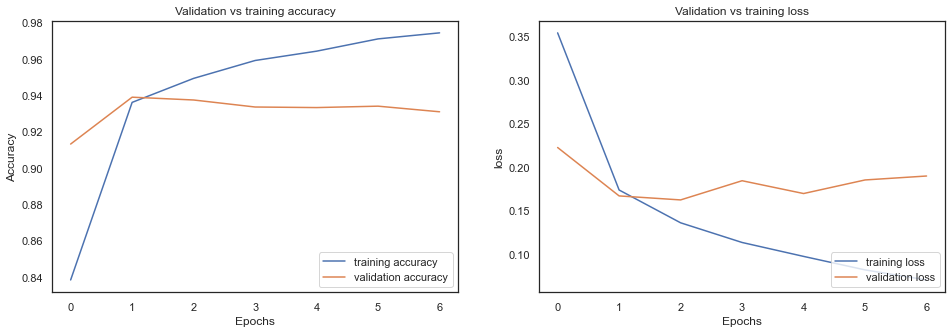

In [60]:
fig, axs = plt.subplots(1,2,figsize=(16,5))
axs[0].plot(lstm_1_drop_1_history.history['accuracy']) 
axs[0].plot(lstm_1_drop_1_history.history['val_accuracy']) 
axs[0].set_title('Validation vs training accuracy')
axs[0].set_ylabel('Accuracy') 
axs[0].set_xlabel('Epochs')
axs[0].legend(['training accuracy', 'validation accuracy'], loc='lower right')

axs[1].plot(lstm_1_drop_1_history.history['loss']) 
axs[1].plot(lstm_1_drop_1_history.history['val_loss']) 
axs[1].set_title('Validation vs training loss')
axs[1].set_ylabel('loss') 
axs[1].set_xlabel('Epochs')
axs[1].legend(['training loss', 'validation loss'], loc='lower right')
plt.show()

In [61]:
# dropout added as a layer after the LSTM layer
lstm_1_drop_2 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=32, input_length=50),
    tf.keras.layers.LSTM(32, return_sequences=False, activation='tanh'), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid")
  ])
lstm_1_drop_2.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.01, mode='max', restore_best_weights=True)

In [62]:
lstm_1_drop_2_history = lstm_1_drop_2.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=0)

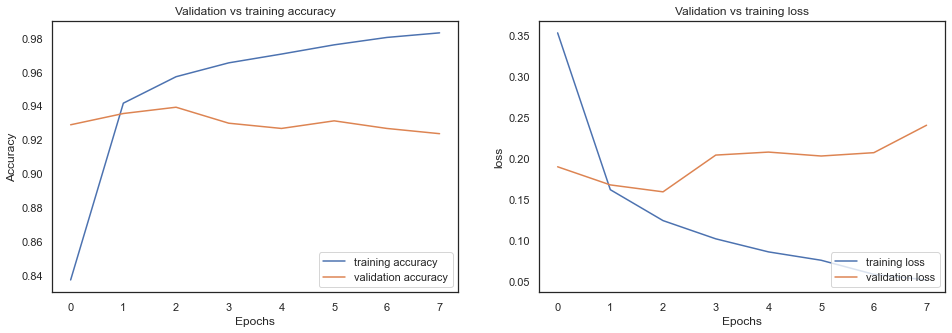

In [63]:
fig, axs = plt.subplots(1,2,figsize=(16,5))
axs[0].plot(lstm_1_drop_2_history.history['accuracy']) 
axs[0].plot(lstm_1_drop_2_history.history['val_accuracy']) 
axs[0].set_title('Validation vs training accuracy')
axs[0].set_ylabel('Accuracy') 
axs[0].set_xlabel('Epochs')
axs[0].legend(['training accuracy', 'validation accuracy'], loc='lower right')

axs[1].plot(lstm_1_drop_2_history.history['loss']) 
axs[1].plot(lstm_1_drop_2_history.history['val_loss']) 
axs[1].set_title('Validation vs training loss')
axs[1].set_ylabel('loss') 
axs[1].set_xlabel('Epochs')
axs[1].legend(['training loss', 'validation loss'], loc='lower right')
plt.show()

In [64]:
# LSTM with batch normalisation
lstm_1_batchnorm = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=32, input_length=50),
    tf.keras.layers.LSTM(32, return_sequences=False, activation='tanh'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation="sigmoid")
  ])
lstm_1_batchnorm.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.01, mode='max', restore_best_weights=True)

In [65]:
lstm_1_batchnorm_history = lstm_1_batchnorm.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=0)

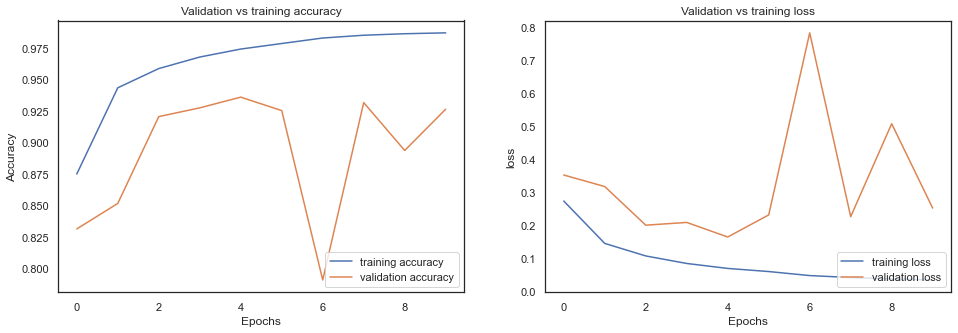

In [66]:
fig, axs = plt.subplots(1,2,figsize=(16,5))
axs[0].plot(lstm_1_batchnorm_history.history['accuracy']) 
axs[0].plot(lstm_1_batchnorm_history.history['val_accuracy']) 
axs[0].set_title('Validation vs training accuracy')
axs[0].set_ylabel('Accuracy') 
axs[0].set_xlabel('Epochs')
axs[0].legend(['training accuracy', 'validation accuracy'], loc='lower right')

axs[1].plot(lstm_1_batchnorm_history.history['loss']) 
axs[1].plot(lstm_1_batchnorm_history.history['val_loss']) 
axs[1].set_title('Validation vs training loss')
axs[1].set_ylabel('loss') 
axs[1].set_xlabel('Epochs')
axs[1].legend(['training loss', 'validation loss'], loc='lower right')
plt.show()

In [67]:
# arrays for the test accuracy and test loss for the regularized LSTMs
lstm_1_test_loss = [lstm_1_drop_1.evaluate(test_padded,  y_test, verbose=0)[0],
                  lstm_1_drop_2.evaluate(test_padded,  y_test, verbose=0)[0],
                  lstm_1_batchnorm.evaluate(test_padded,  y_test, verbose=0)[0]]

lstm_1_test_acc = [lstm_1_drop_1.evaluate(test_padded,  y_test, verbose=0)[1],
                  lstm_1_drop_2.evaluate(test_padded,  y_test, verbose=0)[1],
                  lstm_1_batchnorm.evaluate(test_padded,  y_test, verbose=0)[1]]

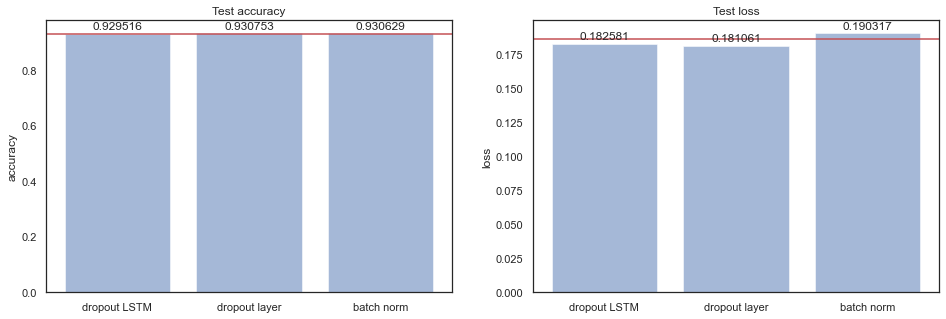

In [68]:
fig, axs = plt.subplots(1,2,figsize=(16,5)) 
# bar chart showing the test accuracy and test loss of each regularised LSTM compared to the original LSTM 
bar1 = axs[0].bar(['dropout LSTM', 'dropout layer', 'batch norm'], lstm_1_test_acc, alpha=0.5)
axs[0].set_ylabel('accuracy')
axs[0].set_title('Test accuracy')
axs[0].bar_label(bar1, padding=2.5)
# horizontal line showing the original LSTMs's (LSTM_1) performance
axs[0].axhline(y=test_acc, color='r', linestyle='-')
bar2 = axs[1].bar(['dropout LSTM', 'dropout layer', 'batch norm'], lstm_1_test_loss, alpha=0.5)
axs[1].set_ylabel('loss')
axs[1].set_title('Test loss')
axs[1].axhline(y=test_loss, color='r', linestyle='-')
axs[1].bar_label(bar2, padding=2.5)
plt.show()

The validation vs training graphs show no noticable improvement with any of the regularization techniques. Althrough the test loss bar chart shows both dropout implementations to reduce dropout, the improvement is marginal. However, as architectures become more complex, the neccessity for dropout often increases so dropout will be kept in the models. Both implementations are near identical in terms of performance so a mix will be used when possible.

### LSTM_1 optimisers and learning rates

To improve model performance experiments are run using different learning rates with different optimisers. The 3 optimisers chosen are Adam, Adamax, and SGD. 

In [69]:
learning_rates = [1e-3, 2e-3, 3e-3, 5e-3, 1e-2] 

In [70]:
# graph plotting function created to plot different learning rates with different optimisers
def plot_lr(lstm_history):
    fig, axs = plt.subplots(1,2,figsize=(16,5))
    # validation accuracy vs training accuracy for cnn_1
    axs[0].plot(lstm_history[0].history['val_accuracy']) 
    axs[0].plot(lstm_history[1].history['val_accuracy']) 
    axs[0].plot(lstm_history[2].history['val_accuracy']) 
    axs[0].plot(lstm_history[3].history['val_accuracy']) 
    axs[0].plot(lstm_history[4].history['val_accuracy'])
    axs[0].set_title('Validation accuracies')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epochs')
    axs[0].legend(learning_rates, loc='lower right')

    axs[1].plot(lstm_history[0].history['val_loss']) 
    axs[1].plot(lstm_history[1].history['val_loss']) 
    axs[1].plot(lstm_history[2].history['val_loss']) 
    axs[1].plot(lstm_history[3].history['val_loss']) 
    axs[1].plot(lstm_history[4].history['val_loss'])
    axs[1].set_title('Validation losses')
    axs[1].set_ylabel('loss') 
    axs[1].set_xlabel('Epochs')
    axs[1].legend(learning_rates, loc='lower right')
    plt.show()

In [71]:
# LSTM with adam optimiser. learning rates are passed as a parameter
def build_lstm_1_adam(lr):
    lstm_1_adam = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(input_dim=5000, output_dim=32, input_length=50),
        tf.keras.layers.LSTM(32, dropout=0.2, return_sequences=False, activation='tanh'), 
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    lstm_1_adam.compile(tf.keras.optimizers.Adam(learning_rate=lr), loss="binary_crossentropy", metrics=['accuracy'])
    return lstm_1_adam

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.01, mode='max', restore_best_weights=True)

In [72]:
# arrays to store each models results  
lstm_history, lstm_test_loss, lstm_test_acc = [], [], []

for y in range(len(learning_rates)):
    lstm_1_adam = build_lstm_1_adam(learning_rates[y])        
    lstm_history.append(lstm_1_adam.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=0))                
    test_loss, test_acc = lstm_1_adam.evaluate(test_padded, y_test, verbose=0)
    print("Accuracy on test data with learning rate {}: {acc:.3f}".format(learning_rates[y], acc=test_acc))
    print("Loss on test data with learning rate {}: {loss:.3f}".format(learning_rates[y], loss=test_loss))

Accuracy on test data with learning rate 0.001: 0.932
Loss on test data with learning rate 0.001: 0.189
Accuracy on test data with learning rate 0.002: 0.931
Loss on test data with learning rate 0.002: 0.176
Accuracy on test data with learning rate 0.003: 0.928
Loss on test data with learning rate 0.003: 0.187
Accuracy on test data with learning rate 0.005: 0.931
Loss on test data with learning rate 0.005: 0.179
Accuracy on test data with learning rate 0.01: 0.919
Loss on test data with learning rate 0.01: 0.208


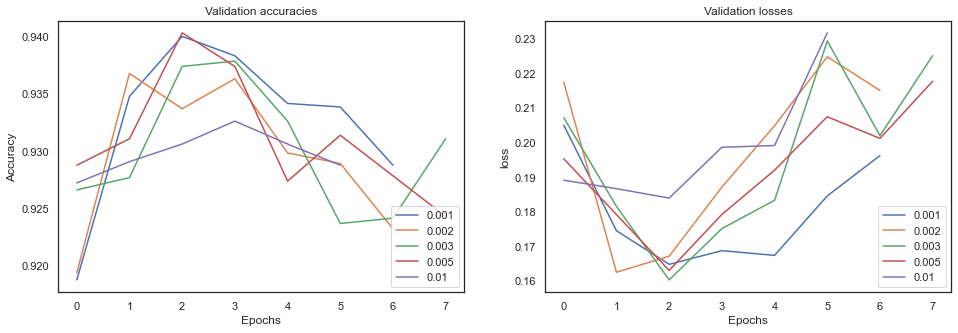

In [73]:
plot_lr(lstm_history)

In [74]:
# LSTM with adamax optimiser. learning rates are passed as a parameter
def build_lstm_1_adamax(lr):
    lstm_1_adamax = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(input_dim=5000, output_dim=32, input_length=50),
        tf.keras.layers.LSTM(32, dropout=0.2, return_sequences=False, activation='tanh'), 
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    lstm_1_adamax.compile(tf.keras.optimizers.Adamax(learning_rate=lr), loss="binary_crossentropy", metrics=['accuracy'])
    return lstm_1_adamax

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.01, mode='max', restore_best_weights=True)

In [75]:
lstm_history, lstm_test_loss, lstm_test_acc = [], [], []

for y in range(len(learning_rates)):
    lstm_1_adamax = build_lstm_1_adamax(learning_rates[y])        
    lstm_history.append(lstm_1_adamax.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=0))                
    test_loss, test_acc = lstm_1_adamax.evaluate(test_padded, y_test, verbose=0)
    print("Accuracy on test data with learning rate {}: {acc:.3f}".format(learning_rates[y], acc=test_acc))
    print("Loss on test data with learning rate {}: {loss:.3f}".format(learning_rates[y], loss=test_loss))

Accuracy on test data with learning rate 0.001: 0.921
Loss on test data with learning rate 0.001: 0.206
Accuracy on test data with learning rate 0.002: 0.933
Loss on test data with learning rate 0.002: 0.172
Accuracy on test data with learning rate 0.003: 0.932
Loss on test data with learning rate 0.003: 0.181
Accuracy on test data with learning rate 0.005: 0.925
Loss on test data with learning rate 0.005: 0.200
Accuracy on test data with learning rate 0.01: 0.921
Loss on test data with learning rate 0.01: 0.194


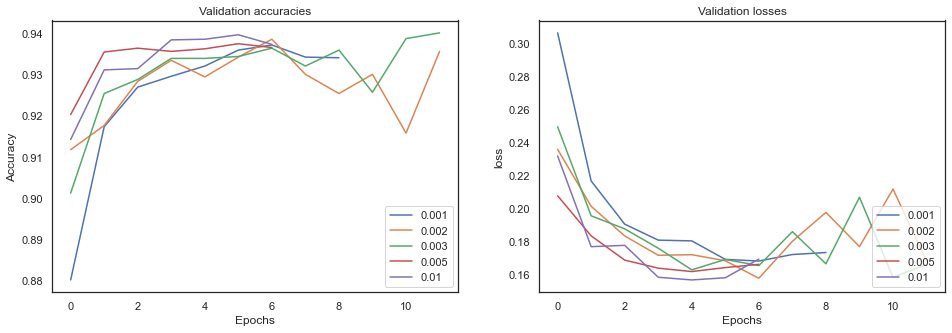

In [76]:
plot_lr(lstm_history)

SGD is built twice. This is because SGD can take a momentum parameter as well so one model is created with momentum and the other without it. 

In [77]:
# LSTM with SGD optimiser. learning rates and momentum are passed as a parameter
def build_lstm_1_sgd(lr, momentum):
    lstm_1_sgd = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(input_dim=5000, output_dim=32, input_length=50),
        tf.keras.layers.LSTM(32, dropout=0.2, return_sequences=False, activation='tanh'), 
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    lstm_1_sgd.compile(tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum), loss="binary_crossentropy", metrics=['accuracy'])
    return lstm_1_sgd

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.01, mode='max', restore_best_weights=True)

In [78]:
lstm_history, lstm_test_loss, lstm_test_acc = [], [], []
for y in range(len(learning_rates)):
    lstm_1_sgd = build_lstm_1_sgd(learning_rates[y], 0) # momentum is not used (set to 0) 
    lstm_history.append(lstm_1_sgd.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=0))                
    test_loss, test_acc = lstm_1_sgd.evaluate(test_padded, y_test, verbose=0)
    print("Accuracy on test data with learning rate {}: {acc:.3f}".format(learning_rates[y], acc=test_acc))
    print("Loss on test data with learning rate {}: {loss:.3f}".format(learning_rates[y], loss=test_loss))

Accuracy on test data with learning rate 0.001: 0.541
Loss on test data with learning rate 0.001: 0.693
Accuracy on test data with learning rate 0.002: 0.551
Loss on test data with learning rate 0.002: 0.692
Accuracy on test data with learning rate 0.003: 0.540
Loss on test data with learning rate 0.003: 0.692
Accuracy on test data with learning rate 0.005: 0.550
Loss on test data with learning rate 0.005: 0.692
Accuracy on test data with learning rate 0.01: 0.557
Loss on test data with learning rate 0.01: 0.692


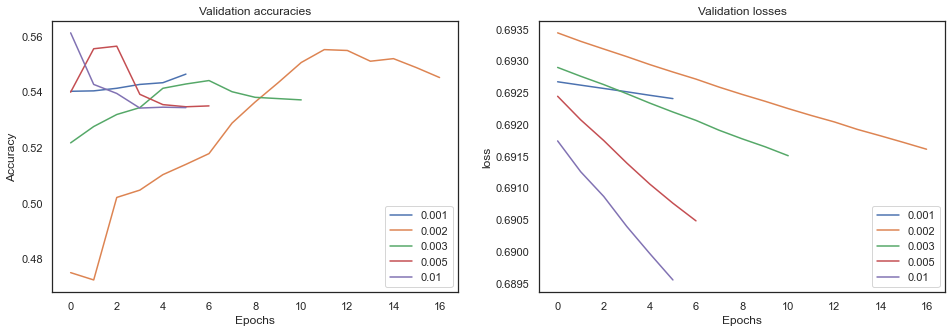

In [79]:
plot_lr(lstm_history)

In [80]:
lstm_history, lstm_test_loss, lstm_test_acc = [], [], []

for y in range(len(learning_rates)):
    lstm_1_sgd = build_lstm_1_sgd(learning_rates[y], 0.9) # momentum is set to 0.9      
    lstm_history.append(lstm_1_sgd.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=0))                
    test_loss, test_acc = lstm_1_sgd.evaluate(test_padded, y_test, verbose=0)
    print("Accuracy on test data with learning rate {}: {acc:.3f}".format(learning_rates[y], acc=test_acc))
    print("Loss on test data with learning rate {}: {loss:.3f}".format(learning_rates[y], loss=test_loss))

Accuracy on test data with learning rate 0.001: 0.533
Loss on test data with learning rate 0.001: 0.692
Accuracy on test data with learning rate 0.002: 0.569
Loss on test data with learning rate 0.002: 0.692
Accuracy on test data with learning rate 0.003: 0.529
Loss on test data with learning rate 0.003: 0.692
Accuracy on test data with learning rate 0.005: 0.882
Loss on test data with learning rate 0.005: 0.296
Accuracy on test data with learning rate 0.01: 0.927
Loss on test data with learning rate 0.01: 0.190


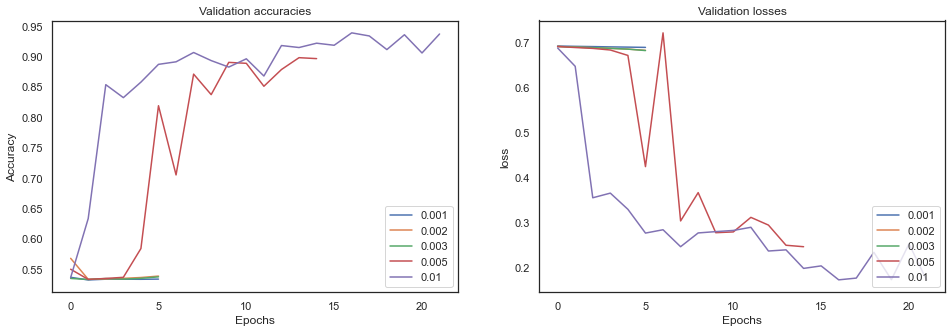

In [81]:
plot_lr(lstm_history)

In [82]:
def plot_val(hist):
    fig, axs = plt.subplots(1,2,figsize=(16,5))
    axs[0].plot(hist.history['accuracy']) 
    axs[0].plot(hist.history['val_accuracy']) 
    axs[0].set_title('Validation vs training accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epochs')
    axs[0].legend(['training accuracy', 'validation accuracy'], loc='lower right')

    axs[1].plot(hist.history['loss']) 
    axs[1].plot(hist.history['val_loss']) 
    axs[1].set_title('Validation vs training loss')
    axs[1].set_ylabel('loss') 
    axs[1].set_xlabel('Epochs')
    axs[1].legend(['training loss', 'validation loss'], loc='lower right')
    plt.show()

Results were unable to influence model performance in a meaningful way. The minor improvements seen with some comobinations are likely to due to random weight initializations. Therefore, the Adam optimiser with default learning rate will stil be used. Instead, model improvement will now be attempted by making the naural network more complex (adding more dense and LSTM layers). 

### LSTM_2

LSTM_2 adds an additional LSTM layer to the network

In [83]:
lstm_2 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=32, input_length=50),
    # return_sequences set to True when the next layer is another LSTM layer
    tf.keras.layers.LSTM(32, dropout=0.2, return_sequences=True, activation='tanh'), 
    tf.keras.layers.LSTM(32, dropout=0.2, return_sequences=False, activation='tanh'), 
    tf.keras.layers.Dense(1, activation="sigmoid")
  ])
lstm_2.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.01, mode='max', restore_best_weights=True)
lstm_2_history = lstm_2.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=0)

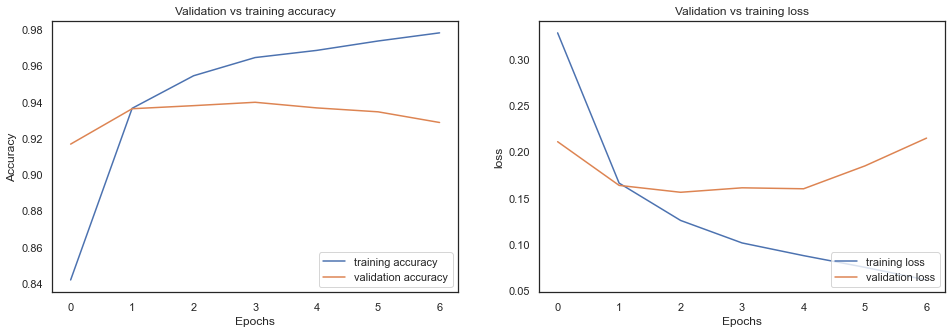

In [84]:
plot_val(lstm_2_history)

In [85]:
test_loss, test_acc = lstm_2.evaluate(test_padded, y_test, verbose=0)
print("Accuracy on test data: {acc:.3f}".format(acc=test_acc))
print("Loss on test data: {loss:.3f}".format(loss=test_loss))

Accuracy on test data: 0.931
Loss on test data: 0.176


### LSTM_3

LSTM_3 adds an additional LSTM layer and dense layer to the network

In [86]:
lstm_3 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=32, input_length=50),
    tf.keras.layers.LSTM(32, dropout=0.2, return_sequences=True, activation='tanh'), 
    tf.keras.layers.LSTM(32, dropout=0.2, return_sequences=False, activation='tanh'), 
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid")
  ])
lstm_3.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.01, mode='max', restore_best_weights=True)
lstm_3_history = lstm_3.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=0)

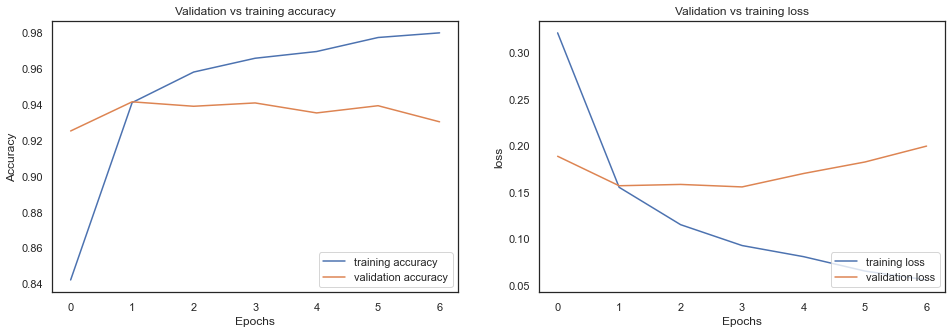

In [87]:
plot_val(lstm_3_history)

In [88]:
test_loss, test_acc = lstm_3.evaluate(test_padded, y_test, verbose=0)
print("Accuracy on test data: {acc:.3f}".format(acc=test_acc))
print("Loss on test data: {loss:.3f}".format(loss=test_loss))

Accuracy on test data: 0.935
Loss on test data: 0.172


### LSTM_4

LSTM_4 adds an additional LSTM layer and two dense layers to the network

In [89]:
lstm_4 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=32, input_length=50),
    tf.keras.layers.LSTM(32, dropout=0.2, return_sequences=True, activation='tanh'), 
    tf.keras.layers.LSTM(32, dropout=0.2, return_sequences=False, activation='tanh'), 
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid")
  ])
lstm_4.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.01, mode='max', restore_best_weights=True)
lstm_4_history = lstm_4.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=0)

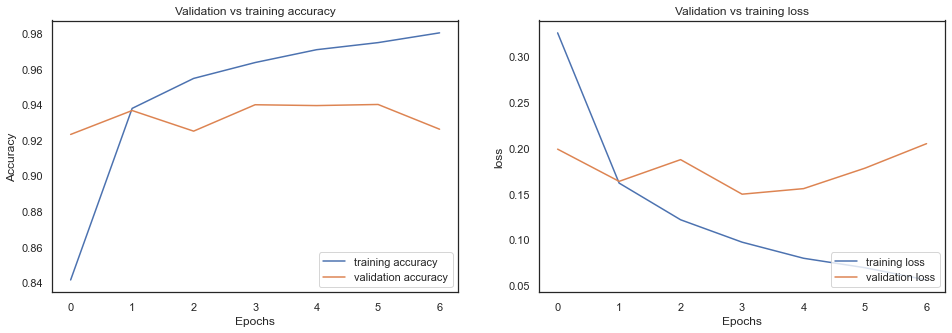

In [90]:
plot_val(lstm_4_history)

In [91]:
test_loss, test_acc = lstm_4.evaluate(test_padded, y_test, verbose=0)
print("Accuracy on test data: {acc:.3f}".format(acc=test_acc))
print("Loss on test data: {loss:.3f}".format(loss=test_loss))

Accuracy on test data: 0.930
Loss on test data: 0.179


### LSTM_5

Results show that LSTM_3 is the best performing based on testing accuracy. LSTM_5 adds bidirectionality to this architecture

In [92]:
lstm_5 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=32, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.2, return_sequences=True, activation='tanh')), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.2, return_sequences=False, activation='tanh')),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid")
  ])
lstm_5.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.01, mode='max', restore_best_weights=True)
lstm_5_history = lstm_2.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=0)

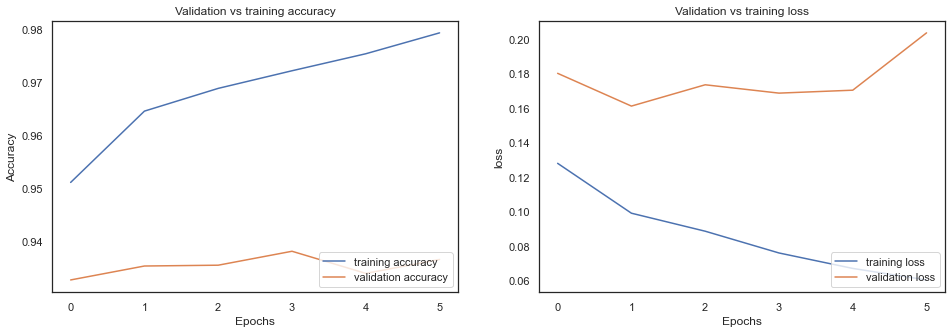

In [93]:
plot_val(lstm_5_history)

In [94]:
test_loss, test_acc = lstm_3.evaluate(test_padded, y_test, verbose=0)
print("Accuracy on test data: {acc:.3f}".format(acc=test_acc))
print("Loss on test data: {loss:.3f}".format(loss=test_loss))

Accuracy on test data: 0.935
Loss on test data: 0.172


Adding bidirectionality to the model shows no further improvement

### BERT model

The BERT model is already pre-trained so is instead fine-tuned on the fake reviews dataset.

In [95]:
# BERT layers imprted from tensorflow hub
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [96]:
# creation of bert using a functional approach [3] 
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

layer = tf.keras.layers.Dropout(0.2, name="dropout")(outputs['pooled_output'])
layer = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(layer)

model = tf.keras.Model(inputs=[text_input], outputs = [layer])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [97]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model.fit(x_test , y_test, epochs=5) # lower number of epochs due to high training time

Epoch 1/5
253/253 [==============================] - 58s 205ms/step - loss: 0.6673 - accuracy: 0.5906
Epoch 2/5
253/253 [==============================] - 52s 207ms/step - loss: 0.5978 - accuracy: 0.6825
Epoch 3/5
253/253 [==============================] - 53s 210ms/step - loss: 0.5545 - accuracy: 0.7234
Epoch 4/5
253/253 [==============================] - 53s 209ms/step - loss: 0.5311 - accuracy: 0.7383
Epoch 5/5
253/253 [==============================] - 53s 208ms/step - loss: 0.5207 - accuracy: 0.7453


In [98]:
model.evaluate(x_test, y_test)

253/253 [==============================] - 53s 207ms/step - loss: 0.4766 - accuracy: 0.7962


[0.4766118824481964, 0.7962161302566528]

### Best model

The best model appears to be LSTM_3 as it achieved the highest testing accuracy and lowest test loss (by a marginal amount).

## Polarity/sentiment assessment

The impact of only training with positive or negative reviews is assessed. The dataframe is first split into a positive and negative dataframe. Ratings of 4 or higher are deemded positive and 2 or lower are deemed negative (3 is seen as neutral so those reviews are ommited). Both datasets remain balanced in terms of fake and real reviews even after splitting. LSTM_3 is used to classify these sentiment divided reviews since it was the best performing on the entire dataset. 

In [124]:
df_positive = dataframe[dataframe['rating'] >=4]

In [125]:
df_positive.shape # positive reviews dataframe created

(32524, 6)

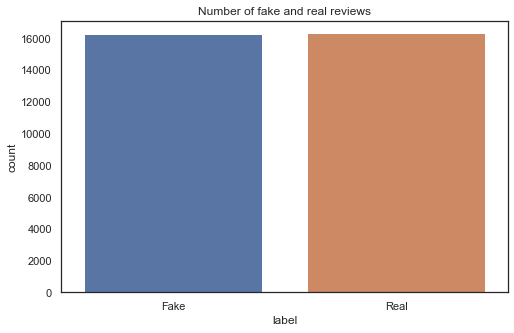

In [126]:
# positive reviews dataset is balanced
plt.figure(figsize=(8,5))
sns.countplot(x = df_positive.label).set_title('Number of fake and real reviews');

In [127]:
df_negative = dataframe[dataframe['rating'] <=2]

In [128]:
df_negative.shape # negative reviews dataframe created

(4122, 6)

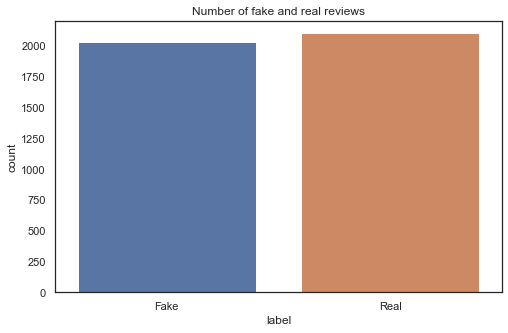

In [129]:
# negative reviews dataset is balanced
plt.figure(figsize=(8,5))
sns.countplot(x = df_negative.label).set_title('Number of fake and real reviews');

In [130]:
# Train-test splits are re-created on the sentiment divided reviews (first positive and then negative) and then the tokenize and
# padding functions are called  

In [131]:
x = df_positive["text"]
y = df_positive["label_encoded"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed, shuffle=True)

In [132]:
train_sequences, test_sequences, word_index = tokenize(5000)
train_padded, test_padded = padding(50)

In [133]:
lstm_3 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=32, input_length=50),
    tf.keras.layers.LSTM(32, dropout=0.2, return_sequences=True, activation='tanh'), 
    tf.keras.layers.LSTM(32, dropout=0.2, return_sequences=False, activation='tanh'), 
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid")
  ])
lstm_3.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.01, mode='max', restore_best_weights=True)
lstm_3_history = lstm_3.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=0)

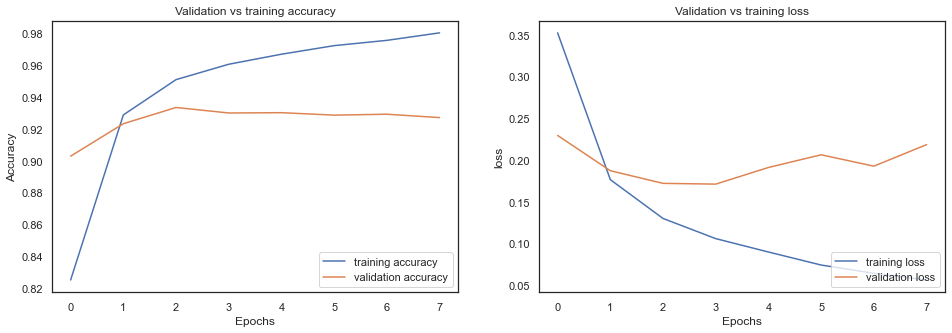

In [134]:
plot_val(lstm_3_history)

In [135]:
test_loss, test_acc = lstm_3.evaluate(test_padded, y_test, verbose=0)
print("Accuracy on test data: {acc:.3f}".format(acc=test_acc))
print("Loss on test data: {loss:.3f}".format(loss=test_loss))

Accuracy on test data: 0.929
Loss on test data: 0.186


In [136]:
x = df_negative["text"]
y = df_negative["label_encoded"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed, shuffle=True)

In [137]:
train_sequences, test_sequences, word_index = tokenize(5000)
train_padded, test_padded = padding(50)

In [138]:
lstm_3 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=32, input_length=50),
    tf.keras.layers.LSTM(32, dropout=0.2, return_sequences=True, activation='tanh'), 
    tf.keras.layers.LSTM(32, dropout=0.2, return_sequences=False, activation='tanh'), 
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid")
  ])
lstm_3.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.01, mode='max', restore_best_weights=True)
lstm_3_history = lstm_3.fit(train_padded, y_train, epochs=num_epochs, validation_split=val_split, shuffle=True, 
                               batch_size=128, callbacks=[callback], verbose=0)

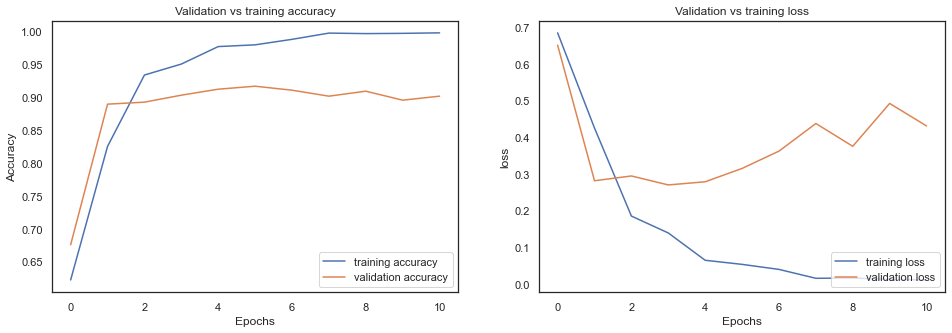

In [139]:
plot_val(lstm_3_history)

In [140]:
test_loss, test_acc = lstm_3.evaluate(test_padded, y_test, verbose=0)
print("Accuracy on test data: {acc:.3f}".format(acc=test_acc))
print("Loss on test data: {loss:.3f}".format(loss=test_loss))

Accuracy on test data: 0.898
Loss on test data: 0.307


The results show that performace on reviews divided by sentiment is lower than training on the entire datasets. Of the two, training on positive reviews led to the higher testing accuracy but this can likely be attributed to the disproportionate amount of reviews that are positive rather than negative. 

In [1]:
# Bibliography
# [1] https://deeplizard.com/learn/video/HcW0DeWRggs
# [2] #https://www.youtube.com/watch?v=Y_hzMnRXjhI&list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S&index=3
# [3] https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3